In [5]:
# Libraries for data preparation & visualisation

import re
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud


# Library to ignore warnings

import warnings
warnings.filterwarnings("ignore")

# Library for assigning sentiment label

from textblob import TextBlob

# Libraries for text analytics

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter  import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries for ML modeling

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report

In [6]:
# Reading in data

data = pd.read_csv('tweets.csv')
data.head()

,id,created_at,text,location
0,1083193473539420160,2019-01-10 02:47:03,@CIBC please explain to me why I want to remai...,Canada
1,1083191479215026176,2019-01-10 02:39:08,"RT @CIBCLiveLabs: We are pleased to announce, ...","Oshawa, Ontario"
2,1083184422709575683,2019-01-10 02:11:05,CIBC World Markets Inc. Decreases Holdings in ...,The Netherlands
3,1083182915826126848,2019-01-10 02:05:06,Le patron de la Banque @cibc s’attend à un ral...,Montréal
4,1083177871881818112,2019-01-10 01:45:03,Your home is a valuable asset. Use your equity...,"Lower Mainland, BC"


In [7]:
# Shape of data

data.shape

(1951, 4)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951 entries, 0 to 1950
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1951 non-null   int64 
 1   created_at  1951 non-null   object
 2   text        1951 non-null   object
 3   location    1509 non-null   object
dtypes: int64(1), object(3)
memory usage: 61.1+ KB


In [9]:
# Dropping 'id'

data = data.drop('id', axis=1)

In [10]:
# Changing datatype for created_at

data['created_at'] = pd.to_datetime(data['created_at'])

In [11]:
# Replacing missing records under location with 'unknown'

data = data.fillna('Unknown')

In [12]:
data.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max
created_at,1951,NaN,NaN,NaN,2019-01-05 12:51:42.564325888,2018-12-30 23:26:02,2019-01-02 21:45:02.500000,2019-01-04 23:54:03,2019-01-08 16:28:06,2019-01-10 02:47:03
text,1951,1768,RT @NHLBlackhawks: Staying warm never looked s...,25,NaN,NaN,NaN,NaN,NaN,NaN
location,1951,429,Unknown,442,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Checking duplicates

data.duplicated().sum()

np.int64(0)

In [14]:
# Checking for missing values

data.isnull().sum().sum()

np.int64(0)

In [17]:
# Language detection

!pip install langdetect
from langdetect import detect

def language_detection(text):

    try:
        language = detect(text)
        return(language)
    except:
        return('error')

data['language'] = data['text'].apply(language_detection)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=ceb7af1b0c6dd6bc3d789e2ef5d757123a35e26b6aaa19f6826fa5f8b8978fe6
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [18]:
data.head()

,created_at,text,location,language
0,2019-01-10 02:47:03,@CIBC please explain to me why I want to remai...,Canada,en
1,2019-01-10 02:39:08,"RT @CIBCLiveLabs: We are pleased to announce, ...","Oshawa, Ontario",en
2,2019-01-10 02:11:05,CIBC World Markets Inc. Decreases Holdings in ...,The Netherlands,en
3,2019-01-10 02:05:06,Le patron de la Banque @cibc s’attend à un ral...,Montréal,fr
4,2019-01-10 01:45:03,Your home is a valuable asset. Use your equity...,"Lower Mainland, BC",en


In [19]:
# Language

data['language'].value_counts()

,count
language,
en,1809
fr,57
ca,13
error,13
so,8
es,6
it,6
ro,5
sv,4


In [20]:
# Filter the dataset to only contain english texts

data = data[data['language']=='en']
data.drop('language', axis=1, inplace=True)

In [21]:
# Shape of data

data.shape

(1809, 3)

In [22]:
# Create new features from 'created_at'

# Day of the week
data['day_of_week'] = data['created_at'].dt.dayofweek
data['day_of_week'] = data['day_of_week'].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',\
                                                   4:'Friday', 5:'Saturday',6:'Sunday'})

In [23]:
# Hour

data['hour']        = data['created_at'].dt.hour + data['created_at'].dt.minute/60

In [24]:
# Value counts for day_of_week

data['day_of_week'].value_counts()

,count
day_of_week,
Wednesday,442
Monday,432
Tuesday,335
Friday,230
Thursday,215
Saturday,92
Sunday,63


In [25]:
# Dropping the 'created_at' attribute

data = data.drop('created_at', axis=1)

In [26]:
# Let's create target column, i.e., sentiment associated with text

# Defining a function to assign sentiments (positive, negative or neutral)

def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'

data['sentiment'] = data['text'].apply(get_sentiment)

In [27]:
# Value counts for sentiment

data['sentiment'].value_counts()

,count
sentiment,
positive,792
neutral,716
negative,301


In [28]:
# function to create labeled barplots


def labeled_barplot(data, feature, target ,perc=False, n=None):

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 5))
    else:
        plt.figure(figsize=(n + 2, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(data=data.sort_values(by=target),x=feature,palette="Paired",hue=target,\
                       order=data[feature].value_counts().index[:n].sort_values(),)

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(100 * p.get_height() / total)  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(label,(x, y),ha="center",va="center",size=12,xytext=(0, 5),textcoords="offset points",)  # annotate the percentage

    plt.show()  # show the plot

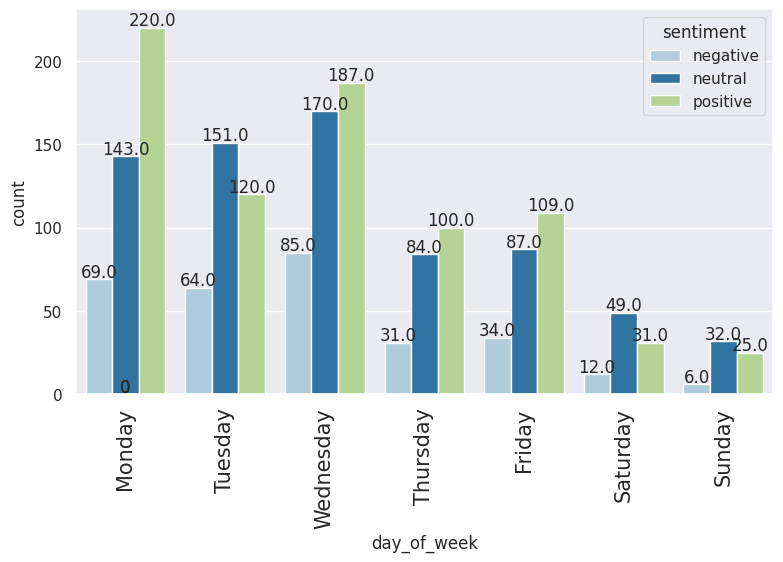

In [29]:
# day_of_week

df = data.copy()

from pandas.api.types import CategoricalDtype
cats     = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)

df['day_of_week']=df['day_of_week'].astype(cat_type)

labeled_barplot(df, 'day_of_week', 'sentiment')

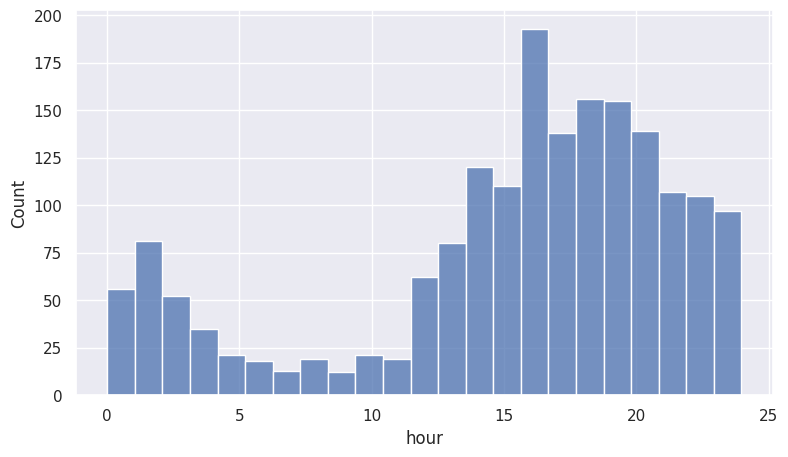

In [30]:
# hour

plt.figure(figsize=(9,5))
sns.histplot(data=data, x='hour');

In [31]:
positive_words = pd.read_csv('positive-words.txt', skiprows=35, names=['words'])
positive_words = positive_words['words'].values.tolist()

In [32]:
negative_words = pd.read_csv('negative-words.txt', skiprows=35, names=['words'])
negative_words = negative_words['words'].values.tolist()

In [33]:
# Let's create new features, i.e., number of positive & negative words associated with each text

# Defining a function to count number of positive & negative words

def count_words(tweet, words):
    count = 0
    for word in tweet.split(' '):
        if word in words:
            count += 1
    return count

data['number_positive_words'] = data['text'].apply(count_words, words=positive_words)
data['number_negative_words'] = data['text'].apply(count_words, words=negative_words)

In [34]:
# Function to create stacked barplots

def stacked_barplot(data, predictor, target):

    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(by=sorter, ascending=False)
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(by=predictor, ascending=True)
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(loc="lower left", frameon=False,)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

sentiment              negative  neutral  positive   All
number_positive_words                                   
All                         301      716       792  1809
0                           285      655       505  1445
1                            15       55       189   259
2                             1        6        85    92
3                             0        0         9     9
4                             0        0         4     4
------------------------------------------------------------------------------------------------------------------------


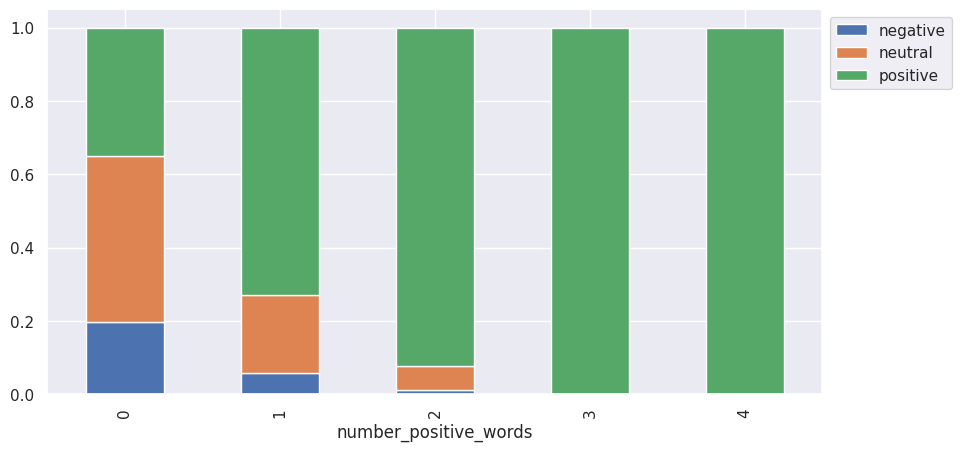

In [35]:
# number_positive_words

stacked_barplot(data, 'number_positive_words', 'sentiment')

sentiment              negative  neutral  positive   All
number_negative_words                                   
All                         301      716       792  1809
0                           189      625       675  1489
1                            82       83       105   270
2                            28        7        12    47
3                             1        1         0     2
4                             1        0         0     1
------------------------------------------------------------------------------------------------------------------------


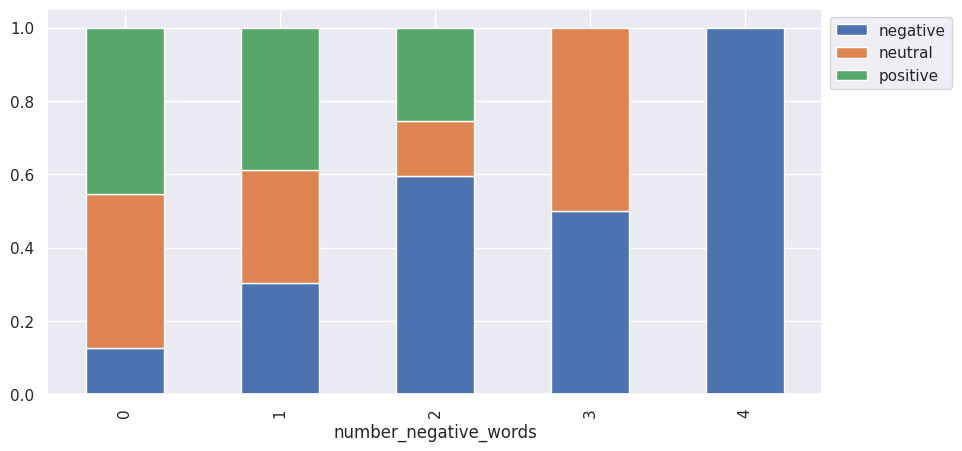

In [36]:
# number_negative_words

stacked_barplot(data, 'number_negative_words', 'sentiment')

In [37]:
data.head()

,text,location,day_of_week,hour,sentiment,number_positive_words,number_negative_words
0,@CIBC please explain to me why I want to remai...,Canada,Thursday,2.783333,neutral,0,0
1,"RT @CIBCLiveLabs: We are pleased to announce, ...","Oshawa, Ontario",Thursday,2.650000,positive,2,1
2,CIBC World Markets Inc. Decreases Holdings in ...,The Netherlands,Thursday,2.183333,neutral,0,0
4,Your home is a valuable asset. Use your equity...,"Lower Mainland, BC",Thursday,1.750000,positive,1,0
5,Both #CIBC and #BMO ads at the Chicago Black H...,Northern Virginia,Thursday,1.633333,negative,0,0


In [38]:
# Convert tweets to lowercase

data['text'] = data['text'].str.lower()

# Remove non-alphanumeric character from tweets such as '@'

def remove_non_alphanumeric(tweet):
    pattern = re.compile('\W')
    x = re.sub(pattern, ' ', tweet)
    return(x)

data['text'] = data['text'].apply(remove_non_alphanumeric)

data.head()

,text,location,day_of_week,hour,sentiment,number_positive_words,number_negative_words
0,cibc please explain to me why i want to remai...,Canada,Thursday,2.783333,neutral,0,0
1,rt cibclivelabs we are pleased to announce ...,"Oshawa, Ontario",Thursday,2.650000,positive,2,1
2,cibc world markets inc decreases holdings in ...,The Netherlands,Thursday,2.183333,neutral,0,0
4,your home is a valuable asset use your equity...,"Lower Mainland, BC",Thursday,1.750000,positive,1,0
5,both cibc and bmo ads at the chicago black h...,Northern Virginia,Thursday,1.633333,negative,0,0


In [40]:
# Tokenize sentences to arrays of words
nltk.download('punkt_tab')
data['tokens'] = data['text'].apply(nltk.word_tokenize)

data.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,text,location,day_of_week,hour,sentiment,number_positive_words,number_negative_words,tokens
0,cibc please explain to me why i want to remai...,Canada,Thursday,2.783333,neutral,0,0,"[cibc, please, explain, to, me, why, i, want, ..."
1,rt cibclivelabs we are pleased to announce ...,"Oshawa, Ontario",Thursday,2.650000,positive,2,1,"[rt, cibclivelabs, we, are, pleased, to, annou..."
2,cibc world markets inc decreases holdings in ...,The Netherlands,Thursday,2.183333,neutral,0,0,"[cibc, world, markets, inc, decreases, holding..."
4,your home is a valuable asset use your equity...,"Lower Mainland, BC",Thursday,1.750000,positive,1,0,"[your, home, is, a, valuable, asset, use, your..."
5,both cibc and bmo ads at the chicago black h...,Northern Virginia,Thursday,1.633333,negative,0,0,"[both, cibc, and, bmo, ads, at, the, chicago, ..."


In [42]:
# Lemmatize the words
nltk.download('wordnet')
lem = WordNetLemmatizer()
data['tokens'] = data['tokens'].apply(lambda x: [lem.lemmatize(word) for word in x])

data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,location,day_of_week,hour,sentiment,number_positive_words,number_negative_words,tokens
0,cibc please explain to me why i want to remai...,Canada,Thursday,2.783333,neutral,0,0,"[cibc, please, explain, to, me, why, i, want, ..."
1,rt cibclivelabs we are pleased to announce ...,"Oshawa, Ontario",Thursday,2.650000,positive,2,1,"[rt, cibclivelabs, we, are, pleased, to, annou..."
2,cibc world markets inc decreases holdings in ...,The Netherlands,Thursday,2.183333,neutral,0,0,"[cibc, world, market, inc, decrease, holding, ..."
4,your home is a valuable asset use your equity...,"Lower Mainland, BC",Thursday,1.750000,positive,1,0,"[your, home, is, a, valuable, asset, use, your..."
5,both cibc and bmo ads at the chicago black h...,Northern Virginia,Thursday,1.633333,negative,0,0,"[both, cibc, and, bmo, ad, at, the, chicago, b..."


In [43]:
# Stemming the words

stem = PorterStemmer()
data['tokens'] = data['tokens'].apply(lambda x: [stem.stem(word) for word in x])

data['tokens'] = data['tokens'].str.join(' ')

data.head()

,text,location,day_of_week,hour,sentiment,number_positive_words,number_negative_words,tokens
0,cibc please explain to me why i want to remai...,Canada,Thursday,2.783333,neutral,0,0,cibc pleas explain to me whi i want to remain ...
1,rt cibclivelabs we are pleased to announce ...,"Oshawa, Ontario",Thursday,2.650000,positive,2,1,rt cibclivelab we are pleas to announc cibc in...
2,cibc world markets inc decreases holdings in ...,The Netherlands,Thursday,2.183333,neutral,0,0,cibc world market inc decreas hold in ing groe...
4,your home is a valuable asset use your equity...,"Lower Mainland, BC",Thursday,1.750000,positive,1,0,your home is a valuabl asset use your equiti t...
5,both cibc and bmo ads at the chicago black h...,Northern Virginia,Thursday,1.633333,negative,0,0,both cibc and bmo ad at the chicago black hawk...


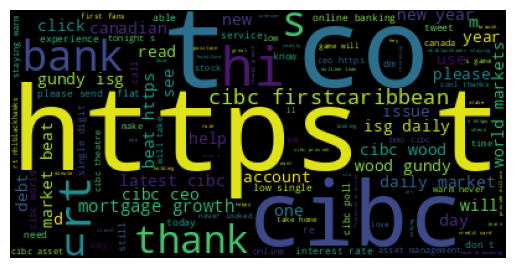

In [44]:
# Let's plot a word cloud to see the difference between original tweets & tweets post data cleaning

# Original tweets

data['text'].to_csv('tweetsonly.csv')
text2 = open('tweetsonly.csv').read()

wordcloud = WordCloud().generate(text2)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

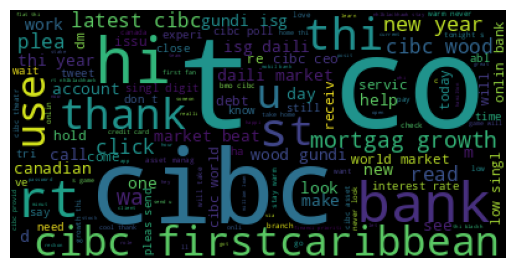

In [45]:

# tweets post data cleaning

data['tokens'].to_csv('cleanedtweetsonly.csv')
text3 = open('cleanedtweetsonly.csv').read()

wordcloud = WordCloud().generate(text3)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [46]:

# Dropping text column

data = data.drop('text', axis=1)

In [47]:
# Clean up locations column

data['location'].value_counts().head(25)

,count
location,
Unknown,410
Canada,342
"Toronto, Ontario",70
The Caribbean,64
Toronto,57
Jamaica,35
United States,30
Barbados,23
Bahamas,20


In [48]:
data = data.drop('location', axis=1)

In [49]:
data['sentiment'] = data['sentiment'].replace({'neutral':0, 'positive':1, 'negative':-1})
data['sentiment'] = data['sentiment'].astype(int)

In [50]:
# Assign features & target as X & y respectively

X = data.drop('sentiment', axis=1)
y = data['sentiment']

In [51]:
# One hot encoding of day_of_week column

X = pd.get_dummies(X, columns=['day_of_week'], drop_first=True)

In [52]:
# Split data into train & test set using stratify to maintain the split of sentiment across train & test sets

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y,\
                                                   shuffle=True)

In [53]:
# Shape of splits

X_train_full.shape

(1447, 10)

In [54]:
X_test.shape

(362, 10)

In [55]:
y_train_full.value_counts(normalize=True)

,proportion
sentiment,
1,0.437457
0,0.395992
-1,0.166551


In [56]:
y_test.value_counts(normalize=True)

,proportion
sentiment,
1,0.439227
0,0.395028
-1,0.165746


In [58]:
import time

# Initialize vectorizer TfidfVectorizer with default parameters, & stop_words as english

vectorizer  = TfidfVectorizer(stop_words='english')

# Initialize oversampler

oversampler = RandomOverSampler(random_state=1)

# Initialize ML models with default parameters

models      = [("SupportVectorMachine",  LinearSVC(random_state=1)),
              ("MultinomialNaiveBayes",  MultinomialNB()),
              ("RandomForest",           RandomForestClassifier(random_state=1)),
              ("XGBoost",                XGBClassifier(random_state=1, eval_metric='mlogloss'))]

results  = []
names    = []

print("Cross Validation Model Performance on Training Set - TfidfVectorizer\n")

# Loop through models & calculate mean cross validated scores
for name, model in models:

    scores   = []
    times    = []

    kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

    for train_index, val_index in kf.split(X_train_full, y_train_full):

        X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
        y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

        # vectorization

        num_tweets_train = vectorizer.fit_transform(X_train['tokens'])
        num_tweets_val   = vectorizer.transform(X_val['tokens'])

        feature_names= vectorizer.get_feature_names_out()

        bow_df_train = pd.DataFrame(num_tweets_train.toarray(), columns=feature_names)
        bow_df_val   = pd.DataFrame(num_tweets_val.toarray(),   columns=feature_names)

        X_train   = X_train.drop('tokens', axis=1)
        X_val     = X_val.drop('tokens', axis=1)

        X_train_f = X_train.reset_index(drop=True).merge(bow_df_train.reset_index(drop=True), left_index=True, right_index=True)
        X_val_f   = X_val.reset_index(drop=True).merge(bow_df_val.reset_index(drop=True), left_index=True, right_index=True)


        # oversampling

        X_train_f_over, y_train_over = oversampler.fit_resample(X_train_f, y_train)

        # model fit & prediction

        start = time.time()
        if name == "XGBoost":
            # Remap y labels for XGBoost: -1 -> 0, 0 -> 1, 1 -> 2
            y_train_over_xgb = y_train_over.map({-1: 0, 0: 1, 1: 2})
            y_val_xgb = y_val.map({-1: 0, 0: 1, 1: 2})
            model.fit(X_train_f_over, y_train_over_xgb)
            y_pred = model.predict(X_val_f)
            score = f1_score(y_val_xgb,y_pred, average='macro') # get avg f1_score across classes
        else:
            model.fit(X_train_f_over, y_train_over)
            y_pred = model.predict(X_val_f)
            score = f1_score(y_val,y_pred, average='macro') # get avg f1_score across classes
        end = time.time()

        time_ = end - start

        scores.append(score)
        times.append(time_)

    names.append(name)
    results.append(sum(scores)/len(scores))

    print(f'{name} : {sum(scores)/len(scores)}')
    print(f'Time : {sum(times)/len(times)}')
    print('\n')

Cross Validation Model Performance on Training Set - TfidfVectorizer

SupportVectorMachine : 0.767620755627658
Time : 0.43167314529418943


MultinomialNaiveBayes : 0.6927979490138597
Time : 0.1247518539428711


RandomForest : 0.7645748518170963
Time : 1.4056700229644776


XGBoost : 0.7574994680049321
Time : 4.041018009185791




In [62]:
pipe       = Pipeline(
                    [('TfidfVectorizer',TfidfVectorizer(stop_words='english')),
                     ('oversampler',    RandomOverSampler(random_state=1)),
                     ('RandomForest',   RandomForestClassifier(random_state=1))])

parameters = {
              'TfidfVectorizer__ngram_range' : [(1,1),(1,2)],
              'TfidfVectorizer__max_features': range(1000,10000,2500),
              'RandomForest__n_estimators'   : range(10,100,25),
              'RandomForest__criterion'      : ['gini', 'entropy'],
              'RandomForest__max_depth'      : range(3,15,3),
              'RandomForest__max_features'   : ['sqrt'],
            }

In [60]:
def GridSearchCV_(estimator, estimator_params, X, y):

    kf = StratifiedKFold(n_splits=3, random_state=1, shuffle=True)

    best_score   = 0
    best_params  = None

    for params_permut in ParameterGrid(estimator_params):

        scores   = np.empty(kf.n_splits)

        estimator.set_params(**params_permut)

        for i, (train_index, val_index) in enumerate(kf.split(X_train_full, y_train_full)):

            X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
            y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

            # vectorization

            num_tweets_train = estimator.steps[0][1].fit_transform(X_train['tokens'])
            num_tweets_val   = estimator.steps[0][1].transform(X_val['tokens'])

            feature_names= estimator.steps[0][1].get_feature_names_out()

            bow_df_train = pd.DataFrame(num_tweets_train.toarray(), columns=feature_names)
            bow_df_val   = pd.DataFrame(num_tweets_val.toarray(),   columns=feature_names)

            X_train   = X_train.drop('tokens', axis=1)
            X_val     = X_val.drop('tokens', axis=1)

            X_train_f = X_train.reset_index(drop=True).merge(bow_df_train.reset_index(drop=True), left_index=True, right_index=True)
            X_val_f   = X_val.reset_index(drop=True).merge(bow_df_val.reset_index(drop=True), left_index=True, right_index=True)

            # oversampling

            X_train_f_over, y_train_over = estimator.steps[1][1].fit_resample(X_train_f, y_train)

            # fit & prediction

            estimator.steps[2][1].fit(X_train_f_over, y_train_over)

            y_pred = estimator.steps[2][1].predict(X_val_f)

            scores[i] = f1_score(y_val,y_pred, average='macro') # get avg weighted f1_score across classes

        scores_mean   = scores.mean()

        if scores_mean>best_score:
            best_params= params_permut
            best_score = scores_mean


    print(f'Best Hyperparameters are:\n {best_params}')
    print(f'Best Score is:\n {best_score}')

In [ ]:
GridSearchCV_(pipe, parameters, X_train_full, y_train_full)

In [ ]:
# The steps can be built into a function

def sentiment(X_sample, X, y):   # X & y are the features & predictions for known dataset
                                 # & X_sample is feature set for data where sentiment(s) are unknown

    pipe_final   = Pipeline(
                [('TfidfVectorizer',TfidfVectorizer(stop_words='english', ngram_range=(1, 1),max_features=1000)),
                 ('oversampler',    RandomOverSampler(random_state=1)),
                 ('RandomForest'   , RandomForestClassifier(random_state=1, criterion='gini',\
                                                             max_depth=12, max_features='auto', \
                                                             n_estimators=85))])

    # vectorization

    num_tweets            = pipe_final.steps[0][1].fit_transform(X['tokens'])
    num_tweets_sample     = pipe_final.steps[0][1].transform(X_sample['tokens'])

    feature_names         = pipe_final.steps[0][1].get_feature_names_out()

    bow_df_full           = pd.DataFrame(num_tweets.toarray(), columns=feature_names)
    bow_df_sample         = pd.DataFrame(num_tweets_sample.toarray(), columns=feature_names)

    X                     = X.drop('tokens', axis=1)
    X_sample              = X_sample.drop('tokens', axis=1)

    feature_names_in_     = list(X.columns)

    X_f                   = X.reset_index(drop=True).merge(bow_df_full.reset_index(drop=True), left_index=True, right_index=True)
    X_sample_f            = X_sample.reset_index(drop=True).merge(bow_df_sample.reset_index(drop=True), left_index=True, right_index=True)

    # oversampling

    X_f_over, y_over      = pipe_final.steps[1][1].fit_resample(X_f, y)

    # model fit & prediction

    pipe_final.steps[2][1].fit(X_f_over, y_over)

    pred                  = pipe_final.steps[2][1].predict(X_sample_f)

    feature_names         = feature_names_in_ + list(pipe_final.steps[0][1].get_feature_names_out())

    return pred, pipe_final.steps[2][1], feature_names, X_f_over, y_over

In [ ]:
# Testing

pred_test, tuned_model, feature_names, X_, y_  = sentiment(X_test, X_train_full, y_train_full)

print('Final Classifier Unbiased Testing Performance:')
print(classification_report(y_test, pred_test))

In [ ]:
from sklearn.preprocessing import scale
from collections import OrderedDict
def class_feature_importance(X, y, class_labels, feature_names, feature_importances, max_top = 20):
    """
    Saves feature importances by class
    Reworked version of https://stackoverflow.com/a/36201964

    Arguments:
    X, y - array of features and labels
    class_labels - labels corresponding to values in y. For example, if y has [0, 1, 2], class_labels can be ['neg', 'pos', 'neutral']
    feature_names - names of columns in X
    feature_importances - obtained from a classifier such as decision tree
    max_top - the maximum number of most important features for each class to keep

    Returns:
    result - dictionary of feature importances by class
    """
    X = scale(X)

    result = {}
    # extract feature importances by class
    for c in set(y):
        result[class_labels[c]] = dict(zip(feature_names, np.mean(X[y == c, :], axis = 0) * feature_importances))

    # sort by importance and keep the most important
    for cname in result.keys():
        result[cname] = sorted(result[cname].items(), key = lambda x: x[1], reverse = True)[:max_top]

    return result

In [ ]:
class_feature_importance(X_, y_, [0,1,-1], \
                         feature_names, tuned_model.feature_importances_)